# Tutorial #2 :: The Extended Kalman Filter
The Kalman filter (and the Extended Kalman Filter) is an incredibly powerful estimation technique. We will begin by describing the linear Kalman filter (this is what is meant when we say "Kalman filter" as opposed to "Extended" or "Unscented" Kalman filters), and then we'll show how this can be extended to nonlinear cases via the extended Kalman filter. 

The Kalman filter, though it does act as a filter, is most useful as a state estimation technique. In fact, given a linear system where the state variables are zero-mean and Gaussian distributed, the Kalman filter is an optimal estimator. We'll provide some rough math below to give some intuition into the code that will follow, but for a more complete understanding of Kalman filters and linear estimation in general, see *Adaptive Filters*, by Ali Sayed. 

Let's begin! 

## The Normal Equation for Optimal Linear Estimation
Linear estimation deals with estimating a random, possibly vector-valued variable $x$ given observations $y$. By default, we assume a vector-valued quantity is a column vector. Traditionally, these estimators are designed to be optimal in the *least squares sense*. In other words, they aim to minimize the error

<center>$\tilde{x} = x - \hat{x}$</center>

where $\hat{x}$ is the estimate of vector $x$. The *mean-squared-error* or MSE of $\tilde{x}$ is given as $\mathbb{E}(\tilde{x}^2)$. One intuitive way of reasoning about $\hat{x}$ is that it must be constructed in such a way that $\tilde{x}$ is uncorrelated with observations $y$ or any function thereof, say $f(y)$. If $\tilde{x}$ *was* correlated with $y$, then additional information could still be gleaned from $y$, indicating that $\hat{x}$ is suboptimal. More formally, the following condition must hold:

<center>
$\tilde{x} \perp f(y) = \hat{x}$
</center>

using the simple observation that $\hat{x}$ is a function of $y$. This is commonly stated as the *orthognality principle*, because it implies that $\mathbb{E}\tilde{x}f(y)^* = 0$ for complex valued $x$ and $y$, or simply $\mathbb{E}\tilde{x}f(y)^T = 0$ for real values. Finally, it can be derived from probability that the optimal estimate of $\hat{x} = f(y)$ given observations $y$ is the conditional expectation

<center> $\hat{x} = \mathbb{E}(x~|~y)$ </center>

Linear estimation limits $f(y)$ to be a liniear function, namely

<center> $f(y) = Ky + b$ </center>

for matrix $K$ and vector $b$. More specifically, we often assume zero-mean random variables $x$ and $y$ such that $\hat{x} = f(y) = Ky$. Given the orthogonality principle, the following must hold for an optimal estimator, denoted $K_o$:

<center>
$\begin{align}
\mathbb{E}(\tilde{x}y^T) &= 0\\
\mathbb{E}((x - K_oy)y^T) &= 0\\
\mathbb{E}(xy^T) - K_o\mathbb{E}(yy^T) &= 0\\
\end{align}$
</center>

or, more compactly,

<center>
$K_oR_y = R_{xy}$
</center>

where $R_{xy}$ represents the covariance matrix corresponding to random variables $x$ and $y$. The above equation is often referred to as the normal equation for optimal linear estimation. In summary, an optimal linear estimator $K_o$ is any such matrix that satisfies $K_o = R_y^{-1}R_{xy}$.

## Introducing the Linear Kalman Filter
We know from the previous section that we're seeking an optimal estimator $K_o$ such that $\hat{x} = K_oy$, where $K_oRy = R_{xy}$.

Now we're going to consider a transformation on $y$ into a new variable $e$:

<center>
$e = Ay$
</center>

for a lower triangular and invertible matrix $A$. The key is that we want each subsequent entry in the vector $e$ to be uncorrelated with the previous entry. In other words, we want to extract from $y$ the key information from all observations, ignoring any cross-correlation. These are called *innovations* of $y$. In other words, we want $R_e$ to be diagonal. 

We are now concerned with estimating $x$ from $e$: $\hat{x}_{|e} = R_{xe}R_e^{-1}e$. In fact, we can show algebraically that the estimators are equivalent--that is, estimating $\hat{x}$ from $e$ is the same as estimating $\hat{x}$ from $y$, but now $R_e$ is block diagonal, meaning it can nicely be split into a sum of individual estimators! In fact, we can write the following iterative formula:

<center>
$\begin{align}
\hat{x}_{|N} &= \hat{x}_{|N-1} + \hat{x}_{e_N}\\
&= \hat{x}_{|N-1} + (\mathbb{E}xe^T_N)R_{e,N}^{-1}e_N
\end{align}$
</center>

where $\hat{x}_{|N}$ denotes the estimate of $x$ using only up to $N$ observations $y$. At this point we have an iterative, causal way of estimating $\hat{x}$, but we haven't yet explained how to get the innovations $e$ from $y$--we've just assumed they exist. In fact, we can construct each innovation $e_i$ by *whitening* the observations $y$: $e_i = y_i - \hat{y}_{i|i-1}$. We'll not dig into the details here, referring the reader again to *Adaptive Filters* by Sayed. 

## State-Space Models
In order to understand Kalman filters, we must first understand state-space representations. State-space models describe the iterative progression of the state, $x$, as well as the observations $y$ as a function of the state. Specifcally, we often write

<center>
$\begin{align}
x_{k+1} &= F_kx_k + B_ku_k + w_k \\
z_{k} &= H_kx_k + v_k
\end{align}$
</center>

where $k$ is the discrete time index, $u$ is the input to the system, and $F$, $B$, and $H$ describe the evolution of the state and the observations--these depend on the physics of the system and the sensors used. Note that the matrices themselves *can* vary with time as well, although they certainly don't have to. Finally, $w_k$ and $v_k$ *must* be zero-mean and white. 

## The Kalman Filter Equations
Here we skip forward *a lot* in the derivation of the Kalman filter, skipping straight to the recursion equations themselves. I hope to fill this material in later, but for now the reader will have to take these equations on faith. 

Given a linear model described in state-space format, and given state variables $x$ and observations $y$ as discussed, the Kalman filter recursion is as folllows, adopting the notation used by Wikipedia:

We begin with a prediction stage:

<center>
$\begin{align}
\hat{x}_{k|k-1} &= F_k\hat{x}_{k-1|k-1} + B_ku_k \\
P_{k|k-1} &= F_kP_{k-1|k-1}F_k^T + Q_k
\end{align}$
</center>

where $P_k$ is the state covariance matrix and $Q_k$ is the process covariance matrix. $P_k$ describes the current uncertainty of any of the given state variables at time $k$ as well as their cross-covariance terms with regard to other state variables. Small elements of $P_k$ indicate accurate state variable estimates. $Q_k$ is often a diagonal matrix whose elements dictate the variance in the sensor measurements--e.g. accelerometer or gyroscope variance due to noise.

Next we have an update stage:
<center>
$\begin{align}
\tilde{y}_k &= z_k - H_k\hat{x}_{k|k-1}\\
S_k &= H_kP_{k|k-1}H_k^T + R_k \\
K_k &= P_{k|k-1}H_k^TS_k^{-1} \\
\hat{x}_{k|k} &= \hat{x}_{k|k-1} + K_k\tilde{y}_k \\
P_{k|k} &= (I - K_kH_k)P_{k|k-1}
\end{align}$
</center>

where $S_k$ is the covariance matrix of the innovation terms, $e$, and $K_k$ is called the Kalman *gain* and dictates how the state is advanced as a function of each prediction.  

These equations are set in stone, so as a designer what must you decide upon for your application-specific Kalman filter? A designer must do the following:

1.  Decide the variances embedded in the measurement covariance matrix $R$
2.  Decide the variances embedded in the process covariance matrix $Q$. 
3.  Design the state transition matrix $F$, any feed forward matrix $B$ (often zero), and the measurement matrix $H$. 
4. Decide on the initial uncertainty of all state variables, $P_{k=0}$ as well as the initial state estimate itself, $x_{k=0}$. 

The problem is that the system is not often linear, and even if it is designing the linear matrices to best represent the dynamics of your system can be difficult.  Enter the Extended Kalman Filter, or EKF. 

## The Extended Kalman Filter
The Extended Kalman Filter (EKF) does not benefit from the same optimality guarantees that the linear Kalman filter does--that is, it's not provably optimal, or at least has yet to be proven optimal. Nevertheless, it is an incredibly powerful tool that performs admirably even with nonlinear systems.  Just because we have yet to *prove* that it's optimal should not dissuade you from using it!

The key idea is very simple--we take the same Kalman filter equations, but where we require linear dynamic matrices such as $F$ and $K$ we instead *create* these matrices by linearizing about the current state estimate. In fact, we can write our code such that we need only provide function handles to our EKF rather than a matrix at all! This undoubtedly adds to computation time, but it can be very convenient for quickly designing very powerful state estimation code. 

Rather than re-write the Kalman filter equations here, we will instead write the EKF as pseudocode, where it is assumed that matrix multiplication is allowed. First, the developer must design a process and a measurement function:

`fstate` predicts the next state from the current state. For example, you might predict the future position of an object based on its current position and its current velocity.

`fmeas` predicts the observation vector $z$ based on the current state estimate. For example, you might have a measurement that consists of the distance between two objects, both who have positions tracked in your state vector. You can predict this range based on your current estimate of their two positions. 

The EKF equations can then be written as follows.

```
[x1,A]=linearize(fstate,x);   
P=A*P*A'+Q;                
[z1,H]=linearize(fmeas,x1);    
P12=P*H';                   
K=P12*inv(H*P12+R);      
x=x1+K*(z-z1);           
P=P-K*P12';             
```

the `linearize` function can be done a number of ways. One generalizabel way uses the addition of *very* small complex numbers to evaluate the gradient (i.e. find the Jacobian) of a function with respect to a given state, $x$. 

```
% Linearization through complex step differentiation
function [z,A]=linearize(fcn,x)
    z=fcn(x);
    n=length(x);
    m=length(z);
    A=zeros(m,n);
    h=n*eps;
    for k=1 to n
        x1=x;
        x1(k)=x1(k)+h*i;
        A(:,k)=imag(fun(x1))/h;
    end
```

where `eps` is a very small number, $i = \sqrt{-1}$, and `imag` extracts the imaginary component of a complex number. 

## An Example of the EKF in Action
First, let's define a couple of functions to help us with our EKF estimation filter, as per the pseudocode written above, which was largely adopting Matlab's syntax.


In [1]:
import numpy as np
import scipy.linalg

def ekfUpdate(fcn_state,x,P,fcn_meas,z,Q,R):
    x1,A = linearize(fcn_state, x)
    P = A*P*A.T + Q
    z1,H = linearize(fcn_meas, x1)
    P12 = P*H.T
    R = scipy.linalg.cholesky( H*P12 + R )
    U = P12*np.linalg.pinv(R)
    dz = (z-z1)
    x = x1 +  U * np.linalg.pinv(R.T)*dz
    P = P - U*U.T
    return (x, P)

def linearize(fcn, x):
    z = fcn(x)
    n = len(x)
    m = len(z)
    A = np.mat( np.zeros( (m,n) ) )
    h = n*np.spacing(1)
    for k in range(n):
        x1 = np.matrix(x, dtype='complex')
        x1[k] += h*1j
        A[:,k] = fcn(x1).imag / h
    return (z, A)

This code will do all of the heavy lifting for us. Now we need to decide what we're trying to estimate (our state) along with how we will describe the dynamics of our system (`fcn_meas`) and our observation function (`fcn_meas`).

Let's start with something practical--let's estimate the 3D position of the person walking around, whose inertial data we loaded and processed in Tutorial [1]. So what should our state vector $x$ contain? Well, it should for sure contain the position of the person, but we should also include the velocity, acceleration, *and* orientation of the person so that we can more easily predict future positions and measurements (observations) based on the current estimates. 

So we'll say $x = [\boldsymbol{p}, \boldsymbol{v}, \boldsymbol{a}, \boldsymbol{\theta}, \boldsymbol{\omega}]^T$, where $\boldsymbol{p}$ is 3D position, $\boldsymbol{v}$ is 3D linear velocity, $\boldsymbol{a}$ is 3D acceleration, and $\boldsymbol{\theta}$ is the 3D rotation of the object with respect to the global frame with corresponding angular velocities $\boldsymbol{\omega}$. 

Let's start with designing our state (process) equation, `fcn_state`. Note that, in addition to the state, we must pass `delta_t` to the state function. This allows us to evolve the state dynamics with knowledge of the elapsed time:

In [2]:
def fcn_state(state, delta_t):
    x = state.item(0)
    y = state.item(1)
    z = state.item(2)
    vx = state.item(3)
    vy = state.item(4)
    vz = state.item(5)
    ax = state.item(6)
    ay = state.item(7)
    az = state.item(8)
    roll = state.item(9)
    pitch = state.item(10)
    yaw = state.item(11)
    droll = state.item(12)
    dpitch = state.item(13)
    dyaw = state.item(14)

    # predicted next state
    s = np.matrix([
            [x + vx*delta_t],
            [y + vy*delta_t],
            [z + vz*delta_t],
            [vx + delta_t*ax],
            [vy + delta_t*ay],
            [vz + delta_t*az],
            [ax],
            [ay],
            [az],
            [roll + delta_t*droll],
            [pitch + delta_t*dpitch],
            [yaw + delta_t*dyaw],
            [droll],
            [dpitch],
            [dyaw],
        ])

    return s

Note that the best we can say about acceleration and angular velocity is that they remain the same. Of course, this will often not be true, but our filter will recognize the discrepency in predicted state and measured observations and make the correct adjustments. 

Next, let's define our observations as a function of our state. We have an accelerometer, a gryoscope, and a magnetometer at our disposal. We will predict our accelerometer values from our state accelerations (and using the  angles to convert the global state variables into the sensor's body frame). We'll similarly predict the gyroscope measurements by looking at the estimated angular velocities. 

Finally, we'll use the magnetometer and accelerometer to generate an estimate of the device's orientation in absolute (global, world, etc.) terms. Accelerometer will give us pitch (rotation about y) and roll (rotation about x) in the world frame, while the magnetometer will give us an absolute yaw (rotation about z) orientation. 

In [3]:
def fcn_meas(state):
    x = state.item(0)
    y = state.item(1)
    z = state.item(2)
    vx = state.item(3)
    vy = state.item(4)
    vz = state.item(5)
    ax = state.item(6)
    ay = state.item(7)
    az = state.item(8)
    roll = state.item(9)
    pitch = state.item(10)
    yaw = state.item(11)
    droll = state.item(12)
    dpitch = state.item(13)
    dyaw = state.item(14)
    
    # Rotation matrices, converting body frame to global frame
    Rx = np.matrix([
            [1, 0, 0],
            [0, np.cos(roll), -np.sin(roll)],
            [0, np.sin(roll), np.cos(roll)],
        ])
    Ry = np.matrix([
            [np.cos(pitch), 0, np.sin(pitch)],
            [0, 1, 0],
            [-np.sin(pitch), 0, np.cos(pitch)],
        ])
    Rz = np.matrix([
            [np.cos(yaw), -np.sin(yaw), 0],
            [np.sin(yaw), np.cos(yaw), 0],
            [0, 0, 1],
        ])
    # yaw-pitch-roll form
    R_b2g = Rz*Ry*Rx
    
    # transposing (inv) gives us a global to body rotation
    R_g2b = R_b2g.T
    
    # transform state estimates to body frame
    acc_body = R_g2b*np.matrix([[ax],[ay],[az]])
    dangle_body = R_g2b*np.matrix([[droll],[dpitch],[dyaw]])
    
    # z is [accel x3], [gyro x3], [orientation x3]
    z = np.matrix([
            [acc_body.item(0)],
            [acc_body.item(1)],
            [acc_body.item(2)],
            [dangle_body.item(0)],
            [dangle_body.item(1)],
            [dangle_body.item(2)],
            [roll],
            [pitch],
            #[yaw],
        ])
    
    return z

So we've related the next state to the current state and we've estimated the observations we should see at some time in the future based on the current state. Both of these will, in conjunction with our covariance matrices, attempt to drive the state etimate to something sensible.

Let's tie it all together now.

In [4]:
import numpy as np

# initialize state
state_init = np.matrix([
        # position
        [0], [0], [0],
        # velocity
        [0], [0], [0], 
        # acceleration
        [0], [0], [0],
        # angles
        [0], [0], [0],
        # angular velocity
        [0], [0], [0],
    ])

# initial state uncertainties
init_cov_pos = 0.0
init_cov_vel = 0.1
init_cov_acc = 0.1
init_cov_ang = 0.0
init_cov_anv = np.pi/10
P_init = np.diag( [
        init_cov_pos, init_cov_pos, init_cov_pos,
        init_cov_vel, init_cov_vel, init_cov_vel,
        init_cov_acc, init_cov_acc, init_cov_acc,
        init_cov_ang, init_cov_ang, init_cov_ang,
        init_cov_anv, init_cov_anv, init_cov_anv,
    ])

# process covariances
cov_pos = 0.1
cov_vel = 0.1
cov_acc = 0.1
cov_ang = np.pi/4
cov_anv = np.pi/4
Q = np.diag( [
        cov_pos, cov_pos, cov_pos/5,
        cov_vel, cov_vel, cov_vel,
        cov_acc, cov_acc, cov_acc,
        cov_ang, cov_ang, cov_ang,
        cov_anv, cov_anv, cov_anv,
    ])

# measurement covariances
cov_meas_acc = 0.50
cov_meas_gry = 0.50
cov_meas_rpy = 0.50
R = np.diag( [
        cov_meas_acc, cov_meas_acc, cov_meas_acc,
        cov_meas_gry, cov_meas_gry, cov_meas_gry,
        cov_meas_rpy, cov_meas_rpy, #cov_meas_rpy,
    ])


The process covariance dictates how much we expect our state variables to vary in a *valid* manner--e.g. how much we might reasonably expect the position to vary on a per-second basis. The measurement covariance dictates how much we can trust each measurement---the more variance, the less trustworthy. 

As in Tutorial [1], let's load and pre-process our dataset.

In [5]:
from scipy import signal

# Load inertial data
data_imu = np.array(np.loadtxt('../data/imudata.txt', skiprows=1))
tstamps = data_imu[:,2]
acc_xyz = data_imu[:,3:6]
gyr_xyz = data_imu[:,6:9]
mag_xyz = data_imu[:,9:12]

# Filter accel. to get gravity vector and linear accel.
b, a = signal.butter(N=4, Wn=4/(100/2), btype='lowpass', analog=False, output='ba')
grav_xyz = signal.filtfilt(b,a,acc_xyz, axis=0)
lin_xyz = acc_xyz - grav_xyz

One more thing is needed, however. In our measurement equation, we've assumed we have a way to measure absolute orientation. We need to actually provide this, given our gravity vectors (low-pass filtered accelerometer) and our magnetometer vectors. This is pretty straight forward, using a little trigonometery. Pitch and Roll can be determined from the gravity vector, and yaw may be determined from the magnetometer when fused with pitch and roll.

In [6]:
orient_rpy = np.array([]).reshape(0,3)

for idx in range(acc_xyz.shape[0]):
    # grav and mag vectors
    grav = grav_xyz[idx,:]
    mag = mag_xyz[idx,:]
    gx, gy, gz = grav
    mx, my, mz = mag/np.linalg.norm(mag)
    
    # get roll, pitch, & yaw
    pitch = np.arcsin( gx/np.linalg.norm(grav) )
    roll = np.arcsin( -gy/np.linalg.norm(grav) )
    x = mx*np.sin(pitch)*np.sin(roll) + my*np.cos(pitch) + mz*np.sin(pitch)*np.cos(roll)
    y = -mx*np.cos(roll) + mz*np.sin(roll)
    
    yaw = np.arctan2(y,x)
    
    # append to array
    orient_rpy = np.vstack([orient_rpy, [roll,pitch,yaw]])

Let's visualize the orientation we calculated to make sure it seems reasonable. We'd expect to see the yaw go through a series of turns corresponding to the right angles in the path traversed by the user. The pitch and roll will likely oscillate as the user takes steps.

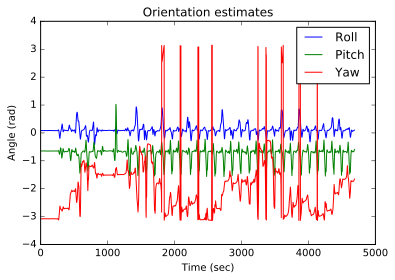

[[ 0.08691149 -0.64812855 -3.08093311]
 [ 0.08659977 -0.6479165  -3.08515372]
 [ 0.08629625 -0.64771081 -3.08192098]
 ..., 
 [ 0.09851975 -0.61045086 -1.66528596]
 [ 0.1002025  -0.60183561 -1.65907802]
 [ 0.10178571 -0.59372609 -1.65297495]]


In [7]:
import matplotlib
import matplotlib.pyplot as plt

# First, some Jupyter plotting config
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

plt.plot(orient_rpy)             
plt.title('Orientation estimates')
plt.xlabel('Time (sec)')
plt.ylabel('Angle (rad)')
plt.legend(['Roll', 'Pitch', 'Yaw'])
plt.show()

print(orient_rpy)

Looks good, except for those spikes which are just $\pm\pi$ ambiguity points. Now all that is left is to loop over our sensor data and make calls to the EKF functions we defined earlier, which we'll do now.

In [8]:
# Some variables we'll need
KSTOP = 3000
state = state_init
P = P_init
time = 0
k = 0
t_last = tstamps[k]

# track our position estimates, so we can plot it
xyz_estimates = []

for k in range(1,KSTOP):
    # get measurement vector
    z = np.matrix([
            [lin_xyz[k,0]],
            [lin_xyz[k,1]],
            [lin_xyz[k,2]],
            [gyr_xyz[k,0]],
            [gyr_xyz[k,1]],
            [gyr_xyz[k,2]],
            [orient_rpy[k,0]],
            [orient_rpy[k,1]],
            #[orient_rpy[k,2]],
        ])
    
    # time change
    dt = tstamps[k] - t_last
    t_last = tstamps[k]
    
    # use time change to bind state process function
    fcn_state_bound = lambda s: fcn_state(s,dt)
    
    # kalman filter update
    state, P = ekfUpdate(fcn_state_bound, state, P, fcn_meas, z, dt*Q, R)
        
    xyz_est = [state.item(0), state.item(1), state.item(2)]
    xyz_estimates.append(xyz_est)
            
print('Measurement time elapsed:', t_last - tstamps[0], 'sec.')

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True

KeyboardInterrupt: 

And we're done! Let's plot the x and y coordinates from above so that we can see how closely we matched up with the earlier plot showing the motion capture ground truth.

In [ ]:
xdata = [p[0] for p in xyz_estimates]
ydata = [p[1] for p in xyz_estimates]

plt.plot(xdata, ydata, 'b', markersize=3)        
plt.title('Position estimate via EKF')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.axis('equal')
plt.show()

Wonderful, right? Okay, what went wrong? The issue is that we don't really have any feedback--there's nothing to prevent the integration of acceleration into velocity terms and the integration of velocity into position.  That is, things will always just drift away without any feedback.

So we have a number of options: 1) if we have periodic GPS signals, we can add position feedback every once in a while, 2) if we have range measurements to anchor nodes we can use range feedback periodically, or 3) one common technique with foot-mounted sensors is something called ZUPT--a zero-velocity update technique where you detect footsteps and then force your state velocities to be equal to zero during those footsteps. This keeps things from diverging too drastically. 

Let's give that last one a shot here. First, let's try to design some metric for detecting footsteps.

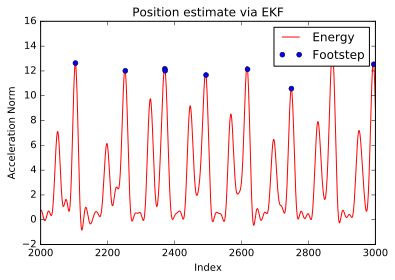

In [9]:
# get total energy in acceleration signal
lin_energy = np.linalg.norm(lin_xyz, axis=1)

# filter these energy spikes so we can easily detect peaks
b, a = signal.butter(N=10, Wn=4/(100/2), btype='lowpass', analog=False, output='ba')
lin_energy_filt = signal.filtfilt(b,a,lin_energy, axis=0)

# peak detection
peaks = np.array(signal.find_peaks_cwt(lin_energy_filt, np.arange(1,10), min_snr=1))
peakvals = lin_energy_filt[peaks]
footstep_idxs = peaks[peakvals > 10.0]

plt.plot(lin_energy_filt, 'r', markersize=3)   
plt.plot(footstep_idxs, lin_energy_filt[footstep_idxs], 'bo', markersize=5)
plt.title('Position estimate via EKF')
plt.xlabel('Index')
plt.ylabel('Acceleration Norm')
plt.xlim([2000, 3000])
plt.legend(['Energy', 'Footstep'])
plt.show()

Now integrating that with our previous EKF execution is quite simple.

In [ ]:
# Some variables we'll need
KSTOP = 3000
state = state_init
P = P_init
time = 0
k = 0
t_last = tstamps[k]

# track our position estimates, so we can plot it
xyz_estimates = []

for k in range(1,KSTOP):
    # get measurement vector
    z = np.matrix([
            [lin_xyz[k,0]],
            [lin_xyz[k,1]],
            [lin_xyz[k,2]],
            [gyr_xyz[k,0]],
            [gyr_xyz[k,1]],
            [gyr_xyz[k,2]],
            [orient_rpy[k,0]],
            [orient_rpy[k,1]],
            #[orient_rpy[k,2]],
        ])
        
    # time change
    dt = tstamps[k] - t_last
    t_last = tstamps[k]
    
    # use time change to bind state process function
    fcn_state_bound = lambda s: fcn_state(s,dt)
    
    # kalman filter update
    state, P = ekfUpdate(fcn_state_bound, state, P, fcn_meas, z, dt*Q, R)
        
    # constrain velocities if footstep detected
    if k in footstep_idxs:
        # velocity is zero with high certainty
        state[3:6] = 0
        P[[3,4,5],[3,4,5]] = 0.01
        # acceleration is zero with high certainty
        state[6:9] = 0
        P[[6,7,8],[6,7,8]] = 0.01
        # angular velocity is also zero with high certainty
        state[12:15] = 0
        P[[12,13,14],[12,13,14]] = 0.01
        
    xyz_est = [state.item(0), state.item(1), state.item(2)]
    xyz_estimates.append(xyz_est)
        
print('Measurement time elapsed:', t_last - tstamps[0], 'sec.')

And, finally, displaying our new EKF estimate with ZUPT corrections at each estimated footstep:

In [ ]:
xdata = [p[0] for p in xyz_estimates]
ydata = [p[1] for p in xyz_estimates]

plt.plot(xdata, ydata, 'b', markersize=3)        
plt.title('Position estimate via EKF')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.axis('equal')
plt.show()

Much better! That's it for now!